In [1]:
import anndata as ad
import gc
import sys
from scipy.sparse import csc_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import heapq
import matplotlib
import os
import umap
from sklearn.decomposition import PCA
import pandas as pd

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

batch_size = 50000
pred_num = 1

cuda


In [3]:
train_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_multiome_phase2_mod2/openproblems_bmmc_multiome_phase2_mod2.censor_dataset.output_train_mod1.h5ad'
train_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_multiome_phase2_mod2/openproblems_bmmc_multiome_phase2_mod2.censor_dataset.output_train_mod2.h5ad'
test_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_multiome_phase2_mod2/openproblems_bmmc_multiome_phase2_mod2.censor_dataset.output_test_mod1.h5ad'
test_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_multiome_phase2_mod2/openproblems_bmmc_multiome_phase2_mod2.censor_dataset.output_test_mod2.h5ad'

In [4]:
input_train_mod1 = ad.read_h5ad(train_mod1_file)
input_train_mod2 = ad.read_h5ad(train_mod2_file)
input_test_mod1 = ad.read_h5ad(test_mod1_file)
input_test_mod2 = ad.read_h5ad(test_mod2_file)

In [5]:
print(input_train_mod1)
print(input_train_mod2)
print(input_test_mod1)
print(input_test_mod2)

AnnData object with n_obs × n_vars = 42492 × 116490
    obs: 'batch'
    var: 'feature_types'
    uns: 'dataset_id', 'gene_activity_var_names', 'organism'
    obsm: 'gene_activity'
    layers: 'counts'
AnnData object with n_obs × n_vars = 42492 × 13431
    obs: 'batch'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 116490
    obs: 'batch'
    var: 'feature_types'
    uns: 'dataset_id', 'gene_activity_var_names', 'organism'
    obsm: 'gene_activity'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 13431
    obs: 'batch'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'


In [6]:
print(sorted(set(input_train_mod1.obs['batch'])))
print(sorted(set(input_train_mod2.obs['batch'])))

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d10', 's3d3', 's3d6', 's3d7']
['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d10', 's3d3', 's3d6', 's3d7']


In [7]:
print(sorted(set(input_test_mod1.obs['batch'])))
print(sorted(set(input_test_mod2.obs['batch'])))

['s4d1', 's4d8', 's4d9']
['s4d1', 's4d8', 's4d9']


In [8]:
mod2_s1d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d1", :]
mod2_s1d2 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d2", :]
mod2_s1d3 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d3", :]
mod2_s2d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d1", :]
mod2_s2d4 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d4", :]
mod2_s2d5 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d5", :]

mod2_s3d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d1", :]
mod2_s3d6 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d6", :]
mod2_s3d7 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d7", :]

mod2_s4d1 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d1", :]
mod2_s4d8 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d8", :]
mod2_s4d9 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d9", :]

In [9]:
mod2_s1d1 = mod2_s1d1.X.toarray()
mod2_s1d2 = mod2_s1d2.X.toarray()
mod2_s1d3 = mod2_s1d3.X.toarray()
mod2_s2d1 = mod2_s2d1.X.toarray()
mod2_s2d4 = mod2_s2d4.X.toarray()
mod2_s2d5 = mod2_s2d5.X.toarray()

mod2_s3d1 = mod2_s3d1.X.toarray()
mod2_s3d6 = mod2_s3d6.X.toarray()
mod2_s3d7 = mod2_s3d7.X.toarray()

mod2_s4d1 = mod2_s4d1.X.toarray()
mod2_s4d8 = mod2_s4d8.X.toarray()
mod2_s4d9 = mod2_s4d9.X.toarray()

In [10]:
print(mod2_s1d1.shape)
print(mod2_s4d1.shape)

(5616, 13431)
(415, 13431)


In [19]:
mod1_train = pd.read_csv('train_atac_counts_8000var_features_normalize.csv')
mod1_test = pd.read_csv('test_atac_counts_8000var_features_normalize.csv')

In [20]:
mod1_train = mod1_train.transpose()
mod1_test = mod1_test.transpose()

In [21]:
mod1_train['batch'] = mod1_train.index.str[-4:]
mod1_test['batch'] = mod1_test.index.str[-4:]

In [22]:
mod1_train = mod1_train.iloc[1:, :]
mod1_train.reset_index(drop=True, inplace=True)

mod1_test = mod1_test.iloc[1:, :]
mod1_test.reset_index(drop=True, inplace=True)

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']

['s4d1', 's4d8', 's4d9']

In [23]:
mod1_s1d1 = mod1_train[mod1_train['batch'] == 's1d1']
mod1_s1d2 = mod1_train[mod1_train['batch'] == 's1d2']
mod1_s1d3 = mod1_train[mod1_train['batch'] == 's1d3']
mod1_s2d1 = mod1_train[mod1_train['batch'] == 's2d1']
mod1_s2d4 = mod1_train[mod1_train['batch'] == 's2d4']
mod1_s2d5 = mod1_train[mod1_train['batch'] == 's2d5']
mod1_s3d1 = mod1_train[mod1_train['batch'] == 's3d1']
mod1_s3d6 = mod1_train[mod1_train['batch'] == 's3d6']
mod1_s3d7 = mod1_train[mod1_train['batch'] == 's3d7']

In [24]:
mod1_s4d1 = mod1_test[mod1_test['batch'] == 's4d1']
mod1_s4d8 = mod1_test[mod1_test['batch'] == 's4d8']
mod1_s4d9 = mod1_test[mod1_test['batch'] == 's4d9']

In [25]:
batch_s1d1 = mod1_s1d1["batch"]
batch_s1d2 = mod1_s1d2["batch"]
batch_s1d3 = mod1_s1d3["batch"]
batch_s2d1 = mod1_s2d1["batch"]
batch_s2d4 = mod1_s2d4["batch"]
batch_s2d5 = mod1_s2d5["batch"]

batch_s3d1 = mod1_s3d1["batch"]
batch_s3d6 = mod1_s3d6["batch"]
batch_s3d7 = mod1_s3d7["batch"]

batch_s4d1 = mod1_s4d1["batch"]
batch_s4d8 = mod1_s4d8["batch"]
batch_s4d9 = mod1_s4d9["batch"]

In [26]:
mod1_s1d1 = mod1_s1d1.drop('batch', axis=1)
mod1_s1d2 = mod1_s1d2.drop('batch', axis=1)
mod1_s1d3 = mod1_s1d3.drop('batch', axis=1)
mod1_s2d1 = mod1_s2d1.drop('batch', axis=1)
mod1_s2d4 = mod1_s2d4.drop('batch', axis=1)
mod1_s2d5 = mod1_s2d5.drop('batch', axis=1)

mod1_s3d1 = mod1_s3d1.drop('batch', axis=1)
mod1_s3d6 = mod1_s3d6.drop('batch', axis=1)
mod1_s3d7 = mod1_s3d7.drop('batch', axis=1)

mod1_s4d1 = mod1_s4d1.drop('batch', axis=1)
mod1_s4d8 = mod1_s4d8.drop('batch', axis=1)
mod1_s4d9 = mod1_s4d9.drop('batch', axis=1)

In [27]:
mod1_s1d1 = mod1_s1d1.to_numpy()
mod1_s1d2 = mod1_s1d2.to_numpy()
mod1_s1d3 = mod1_s1d3.to_numpy()
mod1_s2d1 = mod1_s2d1.to_numpy()
mod1_s2d4 = mod1_s2d4.to_numpy()
mod1_s2d5 = mod1_s2d5.to_numpy()

mod1_s3d1 = mod1_s3d1.to_numpy()
mod1_s3d6 = mod1_s3d6.to_numpy()
mod1_s3d7 = mod1_s3d7.to_numpy()

mod1_s4d1 = mod1_s4d1.to_numpy()
mod1_s4d8 = mod1_s4d8.to_numpy()
mod1_s4d9 = mod1_s4d9.to_numpy()

In [28]:
batch_train = list(batch_s1d1)+list(batch_s1d2)+list(batch_s1d3)+list(batch_s2d1)+list(batch_s2d4)+list(batch_s2d5)
batch_val = list(batch_s3d1)+list(batch_s3d6)+list(batch_s3d7)
batch_test = list(batch_s4d1)+list(batch_s4d8)+list(batch_s4d9)

In [29]:
train_input = [mod1_s1d1, mod1_s1d2, mod1_s1d3, mod1_s2d1, mod1_s2d4, mod1_s2d5]
train_output = [mod2_s1d1, mod2_s1d2, mod2_s1d3, mod2_s2d1, mod2_s2d4, mod2_s2d5]

val_input = [mod1_s3d1, mod1_s3d6, mod1_s3d7]
val_output = [mod2_s3d1, mod2_s3d6, mod2_s3d7]

test_input = [mod1_s4d1, mod1_s4d8, mod1_s4d9]
test_output = [mod2_s4d1, mod2_s4d8, mod2_s4d9]

In [30]:
train_input = train_input + val_input
train_output = train_output + val_output

In [31]:
train_input = np.concatenate(train_input, axis=0)
val_input = np.concatenate(val_input, axis=0)
test_input = np.concatenate(test_input, axis=0)

train_output = np.concatenate(train_output, axis=0)
val_output = np.concatenate(val_output, axis=0)
test_output = np.concatenate(test_output, axis=0)

In [32]:
print(train_input.shape)
print(val_input.shape)
print(test_input.shape)

(37087, 8000)
(7865, 8000)
(1000, 8000)


In [33]:
print(train_output.shape)
print(val_output.shape)
print(test_output.shape)

(37087, 13431)
(7865, 13431)
(1000, 13431)


In [38]:
train_input = np.float64(train_input)
train_output = np.float64(train_output)
val_input = np.float64(val_input)
val_output = np.float64(val_output)
test_input = np.float64(test_input)
test_output = np.float64(test_output)

In [39]:
train_input = torch.from_numpy(train_input)
train_output = torch.from_numpy(train_output)
val_input = torch.from_numpy(val_input)
val_output = torch.from_numpy(val_output)
test_input = torch.from_numpy(test_input)
test_output = torch.from_numpy(test_output)

In [40]:
train_input = train_input.float()
train_output = train_output.float()
val_input = val_input.float()
val_output = val_output.float()
test_input = test_input.float()
test_output = test_output.float()

In [41]:
train_input = train_input.to(device)
train_output = train_output.to(device)
val_input = val_input.to(device)
val_output = val_output.to(device)
test_input = test_input.to(device)
test_output = test_output.to(device)

In [42]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_train)):
    if batch_train[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_train[i]] = k
    batch_train[i] = batch_lib[batch_train[i]]

In [43]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_val)):
    if batch_val[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_val[i]] = k
    batch_val[i] = batch_lib[batch_val[i]]

In [44]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_test)):
    if batch_test[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_test[i]] = k
    batch_test[i] = batch_lib[batch_test[i]]

In [45]:
batch_train = batch_train + batch_val

In [46]:
train_output = train_output[:, 0:pred_num]
train_output.shape

torch.Size([37087, 1])

In [47]:
val_output = val_output[:, 0:pred_num]
val_output.shape

torch.Size([7865, 1])

In [48]:
test_output = test_output[:, 0:pred_num]
test_output.shape

torch.Size([1000, 1])

In [49]:
train_ds = TensorDataset(train_input, train_output)
train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True)

In [50]:
input_feature = train_input.shape[1]
output_feature = pred_num

In [51]:
# auto-encoder model
# base model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.linear1 = nn.Linear(input_feature, input_feature//16)
        self.linear2 = nn.Linear(input_feature//2, input_feature//4)
        self.linear3 = nn.Linear(input_feature//4, input_feature//8)
        self.linear4 = nn.Linear(input_feature//8, input_feature//16)
        
        self.linear5 = nn.Linear(input_feature//16, pred_num)
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.15)
        
        self.linear = nn.Linear(input_feature, pred_num)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
#         x = self.linear2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
        
#         x = self.linear3(x)
#         x = self.relu(x)
        
#         x = self.linear4(x)
#         x = self.relu(x)
        
        output = self.linear5(x)
        
        return output.float()

In [52]:
PATH = 'No_norm_model_DNA_RNA_couns_normalize'

In [53]:
def fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output):
    # plt.rcParams['figure.figsize'] = [40, 40]
    val_best = float('inf')
    train_pred_output = []
    val_pred_output = []
    for epoch in range(num_epochs):
        for x,y in train_dl:
            model = model.train()
            pred = model(x)
            # print(y.shape, pred.shape)
            # y = torch.reshape(y, (y.shape[0], 1))
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            opt.zero_grad()

        if epoch % 100 == 0:
            model = model.eval()
            
            train_pred = model(train_input)
            # train_output = torch.reshape(train_output, (train_output.shape[0], 1))
            train_loss = loss_fn(train_pred, train_output)
            train_loss = torch.sqrt(train_loss)
            train_loss = train_loss.cpu().detach().numpy()
            
            val_pred = model(val_input)
            # val_output = torch.reshape(val_output, (val_output.shape[0], 1))
            val_loss = loss_fn(val_pred, val_output)
            val_loss = torch.sqrt(val_loss)
            val_loss = val_loss.cpu().detach().numpy()
            
            test_pred = model(test_input)
            # val_output = torch.reshape(val_output, (val_output.shape[0], 1))
            test_loss = loss_fn(test_pred, test_output)
            test_loss = torch.sqrt(test_loss)
            test_loss = test_loss.cpu().detach().numpy()
            
            if val_loss < val_best:
                torch.save(model.state_dict(), PATH)
                val_best = val_loss
                
            print('Epoch ', epoch, 'Train_loss: ', train_loss, ' Validation_loss: ', val_loss, ' Test_loss: ', test_loss)
        if epoch % 1000 == 0:
            colors = ['red','green','blue','purple', 'yellow', 'orange']
            figure, ax = plt.subplots(1, 3, figsize = (13, 3*1))
            for i in range(1):
                ax[0].scatter(train_output.cpu().detach().numpy()[:, 0], train_pred.cpu().detach().numpy()[:, 0], c=batch_train, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[0].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[0].set_title('Train data result ' + str(i+1))
                ax[0].set_xlabel('train')
                ax[0].set_ylabel('pred')

                ax[1].scatter(val_output.cpu().detach().numpy()[:, 0], val_pred.cpu().detach().numpy()[:, 0], c=batch_val, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[1].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[1].set_title('Validation data result ' + str(i+1))
                ax[1].set_xlabel('true')
                ax[1].set_ylabel('pred')

                ax[2].scatter(test_output.cpu().detach().numpy()[:, 0], test_pred.cpu().detach().numpy()[:, 0], c=batch_test, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[2].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[2].set_title('Test data result ' + str(i+1))
                ax[2].set_xlabel('true')
                ax[2].set_ylabel('pred')
            
            plt.show()
            # train_pred_output.append([train_pred.cpu().detach().numpy(), train_output.cpu().detach().numpy()])
            # val_pred_output.append([val_pred.cpu().detach().numpy(), val_output.cpu().detach().numpy()])
    return train_pred.cpu().detach().numpy(), train_output.cpu().detach().numpy(), val_pred.cpu().detach().numpy(), val_output.cpu().detach().numpy()

Epoch  0 Train_loss:  0.12926106  Validation_loss:  0.1380525  Test_loss:  0.068588436


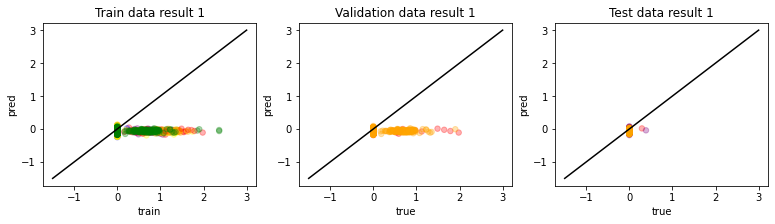

Epoch  100 Train_loss:  0.10807674  Validation_loss:  0.11576116  Test_loss:  0.039783474
Epoch  200 Train_loss:  0.10729331  Validation_loss:  0.11493596  Test_loss:  0.03964438
Epoch  300 Train_loss:  0.10679492  Validation_loss:  0.11443708  Test_loss:  0.039230846
Epoch  400 Train_loss:  0.10638088  Validation_loss:  0.11403072  Test_loss:  0.038747456
Epoch  500 Train_loss:  0.106011294  Validation_loss:  0.113669895  Test_loss:  0.038253974
Epoch  600 Train_loss:  0.10567333  Validation_loss:  0.113338955  Test_loss:  0.037797518
Epoch  700 Train_loss:  0.10536066  Validation_loss:  0.11303164  Test_loss:  0.037378047
Epoch  800 Train_loss:  0.1050689  Validation_loss:  0.11274287  Test_loss:  0.036991958
Epoch  900 Train_loss:  0.10479496  Validation_loss:  0.112470485  Test_loss:  0.036638986
Epoch  1000 Train_loss:  0.10453666  Validation_loss:  0.112212814  Test_loss:  0.03630721


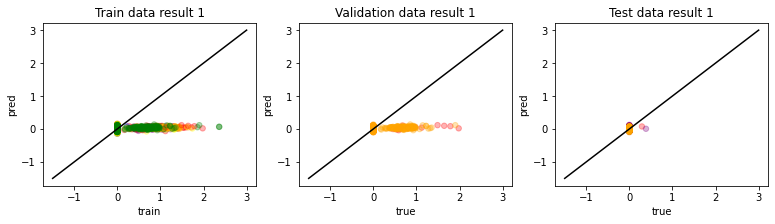

Epoch  1100 Train_loss:  0.10429132  Validation_loss:  0.11196609  Test_loss:  0.036011927
Epoch  1200 Train_loss:  0.1040579  Validation_loss:  0.1117301  Test_loss:  0.035735533
Epoch  1300 Train_loss:  0.10383502  Validation_loss:  0.11150392  Test_loss:  0.035476755
Epoch  1400 Train_loss:  0.103622116  Validation_loss:  0.11128693  Test_loss:  0.035232894
Epoch  1500 Train_loss:  0.10341747  Validation_loss:  0.11107745  Test_loss:  0.035013106
Epoch  1600 Train_loss:  0.10322074  Validation_loss:  0.110875584  Test_loss:  0.034796115
Epoch  1700 Train_loss:  0.10303148  Validation_loss:  0.11068015  Test_loss:  0.034604896
Epoch  1800 Train_loss:  0.102848984  Validation_loss:  0.110491514  Test_loss:  0.034418736
Epoch  1900 Train_loss:  0.10267279  Validation_loss:  0.110308655  Test_loss:  0.034243938
Epoch  2000 Train_loss:  0.102502204  Validation_loss:  0.11013095  Test_loss:  0.034079783


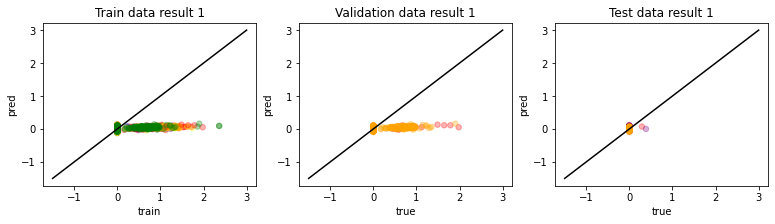

Epoch  2100 Train_loss:  0.10233691  Validation_loss:  0.10995801  Test_loss:  0.033929598
Epoch  2200 Train_loss:  0.10217653  Validation_loss:  0.109790206  Test_loss:  0.03377946
Epoch  2300 Train_loss:  0.10202042  Validation_loss:  0.10962607  Test_loss:  0.033643585
Epoch  2400 Train_loss:  0.101868585  Validation_loss:  0.10946582  Test_loss:  0.033522982
Epoch  2500 Train_loss:  0.10172061  Validation_loss:  0.10930894  Test_loss:  0.03340381
Epoch  2600 Train_loss:  0.101575956  Validation_loss:  0.1091559  Test_loss:  0.03329252
Epoch  2700 Train_loss:  0.1014349  Validation_loss:  0.109005675  Test_loss:  0.03319079
Epoch  2800 Train_loss:  0.101297125  Validation_loss:  0.10885849  Test_loss:  0.033099752
Epoch  2900 Train_loss:  0.10116212  Validation_loss:  0.10871457  Test_loss:  0.03300053
Epoch  3000 Train_loss:  0.10103001  Validation_loss:  0.10857324  Test_loss:  0.032918453


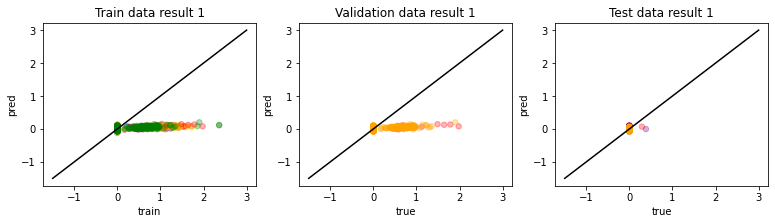

Epoch  3100 Train_loss:  0.10090039  Validation_loss:  0.10843444  Test_loss:  0.032836728
Epoch  3200 Train_loss:  0.10077337  Validation_loss:  0.10829801  Test_loss:  0.032756153
Epoch  3300 Train_loss:  0.10064848  Validation_loss:  0.10816331  Test_loss:  0.032690648
Epoch  3400 Train_loss:  0.100525804  Validation_loss:  0.10803091  Test_loss:  0.032627817
Epoch  3500 Train_loss:  0.10040521  Validation_loss:  0.10790015  Test_loss:  0.032572467
Epoch  3600 Train_loss:  0.10028635  Validation_loss:  0.10777157  Test_loss:  0.032516163
Epoch  3700 Train_loss:  0.100169204  Validation_loss:  0.10764479  Test_loss:  0.032463025
Epoch  3800 Train_loss:  0.10005395  Validation_loss:  0.107519746  Test_loss:  0.032416515
Epoch  3900 Train_loss:  0.09994011  Validation_loss:  0.107395686  Test_loss:  0.032371003
Epoch  4000 Train_loss:  0.09982785  Validation_loss:  0.107273586  Test_loss:  0.03233002


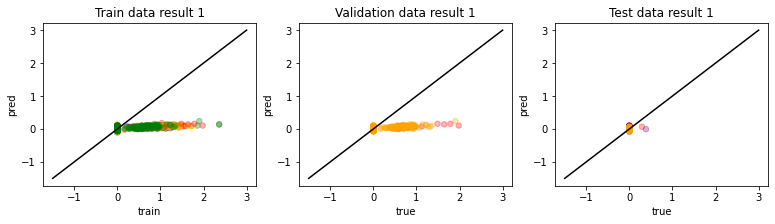

Epoch  4100 Train_loss:  0.09971666  Validation_loss:  0.10715208  Test_loss:  0.03229577
Epoch  4200 Train_loss:  0.09960698  Validation_loss:  0.10703195  Test_loss:  0.032259468
Epoch  4300 Train_loss:  0.09949852  Validation_loss:  0.10691292  Test_loss:  0.03223248
Epoch  4400 Train_loss:  0.09939134  Validation_loss:  0.106794916  Test_loss:  0.032207742
Epoch  4500 Train_loss:  0.09928492  Validation_loss:  0.10667782  Test_loss:  0.03218724
Epoch  4600 Train_loss:  0.09917983  Validation_loss:  0.10656225  Test_loss:  0.032159932
Epoch  4700 Train_loss:  0.09907565  Validation_loss:  0.1064473  Test_loss:  0.032140255
Epoch  4800 Train_loss:  0.098972194  Validation_loss:  0.106333025  Test_loss:  0.032130804
Epoch  4900 Train_loss:  0.09886956  Validation_loss:  0.10621972  Test_loss:  0.032111004
Epoch  5000 Train_loss:  0.098767586  Validation_loss:  0.10610638  Test_loss:  0.032107305


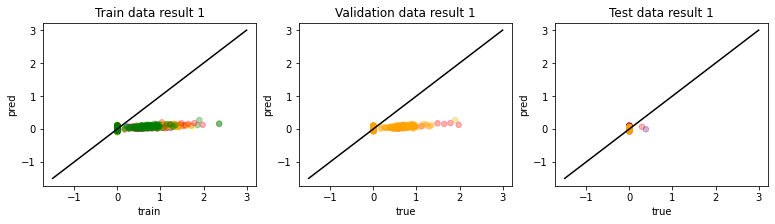

Epoch  5100 Train_loss:  0.09866636  Validation_loss:  0.105993874  Test_loss:  0.032098867
Epoch  5200 Train_loss:  0.09856591  Validation_loss:  0.105881654  Test_loss:  0.0320961
Epoch  5300 Train_loss:  0.098465875  Validation_loss:  0.10577048  Test_loss:  0.032091048
Epoch  5400 Train_loss:  0.09836661  Validation_loss:  0.1056594  Test_loss:  0.032094292
Epoch  5500 Train_loss:  0.09826755  Validation_loss:  0.105549395  Test_loss:  0.032092247
Epoch  5600 Train_loss:  0.09816919  Validation_loss:  0.1054388  Test_loss:  0.032103833
Epoch  5700 Train_loss:  0.09807119  Validation_loss:  0.10532874  Test_loss:  0.03210757
Epoch  5800 Train_loss:  0.09797372  Validation_loss:  0.10521954  Test_loss:  0.032109242
Epoch  5900 Train_loss:  0.09787654  Validation_loss:  0.105110295  Test_loss:  0.032113515
Epoch  6000 Train_loss:  0.09777962  Validation_loss:  0.105001315  Test_loss:  0.032125898


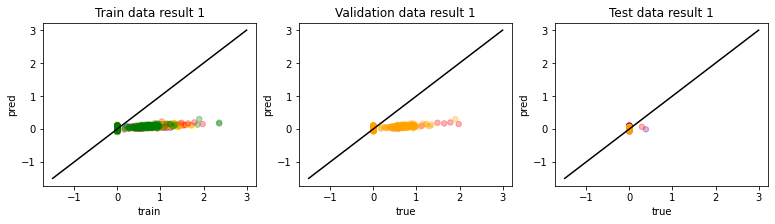

Epoch  6100 Train_loss:  0.097682975  Validation_loss:  0.10489222  Test_loss:  0.03213675
Epoch  6200 Train_loss:  0.09758682  Validation_loss:  0.104783505  Test_loss:  0.032153968
Epoch  6300 Train_loss:  0.097490765  Validation_loss:  0.1046748  Test_loss:  0.032167684
Epoch  6400 Train_loss:  0.09739494  Validation_loss:  0.10456631  Test_loss:  0.032181527
Epoch  6500 Train_loss:  0.09729921  Validation_loss:  0.10445831  Test_loss:  0.03219523
Epoch  6600 Train_loss:  0.0972037  Validation_loss:  0.104349576  Test_loss:  0.03222893
Epoch  6700 Train_loss:  0.09710842  Validation_loss:  0.10424148  Test_loss:  0.032245778
Epoch  6800 Train_loss:  0.09701305  Validation_loss:  0.10413317  Test_loss:  0.032264885
Epoch  6900 Train_loss:  0.09691791  Validation_loss:  0.104024775  Test_loss:  0.032298222
Epoch  7000 Train_loss:  0.09682274  Validation_loss:  0.10391634  Test_loss:  0.03232543


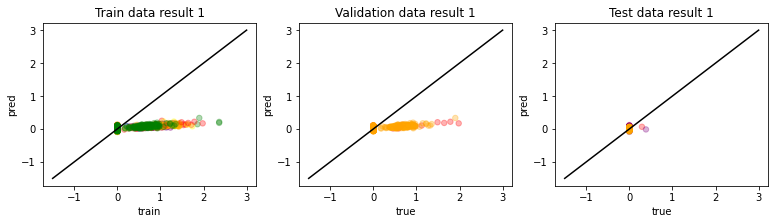

Epoch  7100 Train_loss:  0.096727654  Validation_loss:  0.10380823  Test_loss:  0.03234968
Epoch  7200 Train_loss:  0.09663264  Validation_loss:  0.10369994  Test_loss:  0.03237529
Epoch  7300 Train_loss:  0.096537694  Validation_loss:  0.10359119  Test_loss:  0.032410946
Epoch  7400 Train_loss:  0.096442655  Validation_loss:  0.10348274  Test_loss:  0.03244143
Epoch  7500 Train_loss:  0.09634753  Validation_loss:  0.10337381  Test_loss:  0.032476366
Epoch  7600 Train_loss:  0.09625228  Validation_loss:  0.10326452  Test_loss:  0.032517776
Epoch  7700 Train_loss:  0.0961568  Validation_loss:  0.10315578  Test_loss:  0.032542154
Epoch  7800 Train_loss:  0.09606165  Validation_loss:  0.10304627  Test_loss:  0.032586183
Epoch  7900 Train_loss:  0.095966324  Validation_loss:  0.10293686  Test_loss:  0.03262847
Epoch  8000 Train_loss:  0.09587071  Validation_loss:  0.10282732  Test_loss:  0.032662034


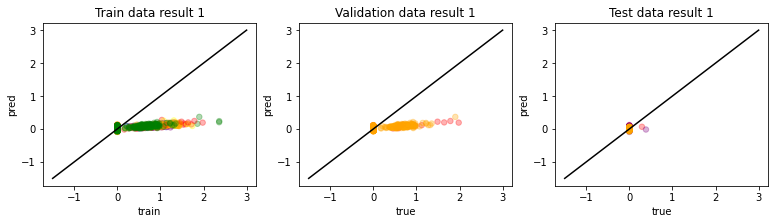

Epoch  8100 Train_loss:  0.095774956  Validation_loss:  0.10271752  Test_loss:  0.032703392
Epoch  8200 Train_loss:  0.09567903  Validation_loss:  0.102607064  Test_loss:  0.032742176
Epoch  8300 Train_loss:  0.09558309  Validation_loss:  0.102496795  Test_loss:  0.03278728
Epoch  8400 Train_loss:  0.09548667  Validation_loss:  0.10238601  Test_loss:  0.03282846
Epoch  8500 Train_loss:  0.09539034  Validation_loss:  0.102275  Test_loss:  0.032875694
Epoch  8600 Train_loss:  0.09529361  Validation_loss:  0.102163516  Test_loss:  0.032920443
Epoch  8700 Train_loss:  0.09519695  Validation_loss:  0.1020523  Test_loss:  0.03296399
Epoch  8800 Train_loss:  0.09509979  Validation_loss:  0.1019405  Test_loss:  0.033003286
Epoch  8900 Train_loss:  0.09500227  Validation_loss:  0.10182757  Test_loss:  0.03306496
Epoch  9000 Train_loss:  0.0949046  Validation_loss:  0.10171481  Test_loss:  0.033114694


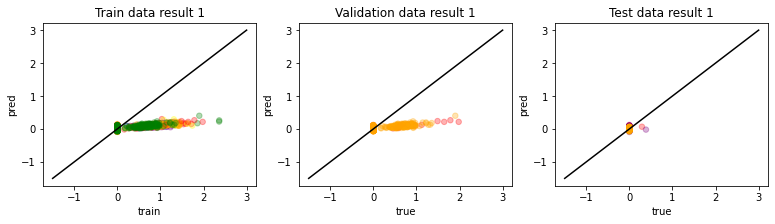

Epoch  9100 Train_loss:  0.09480699  Validation_loss:  0.101602115  Test_loss:  0.03315797
Epoch  9200 Train_loss:  0.09470859  Validation_loss:  0.101488754  Test_loss:  0.03321223
Epoch  9300 Train_loss:  0.0946102  Validation_loss:  0.101375096  Test_loss:  0.03326029
Epoch  9400 Train_loss:  0.094511405  Validation_loss:  0.10126092  Test_loss:  0.03331984
Epoch  9500 Train_loss:  0.094412394  Validation_loss:  0.10114619  Test_loss:  0.0333707
Epoch  9600 Train_loss:  0.094312705  Validation_loss:  0.10103087  Test_loss:  0.033430777
Epoch  9700 Train_loss:  0.094212964  Validation_loss:  0.10091555  Test_loss:  0.033477664
Epoch  9800 Train_loss:  0.09411278  Validation_loss:  0.10079924  Test_loss:  0.033540823
Epoch  9900 Train_loss:  0.09401235  Validation_loss:  0.100683145  Test_loss:  0.033598147
Epoch  10000 Train_loss:  0.093911625  Validation_loss:  0.10056624  Test_loss:  0.033650726


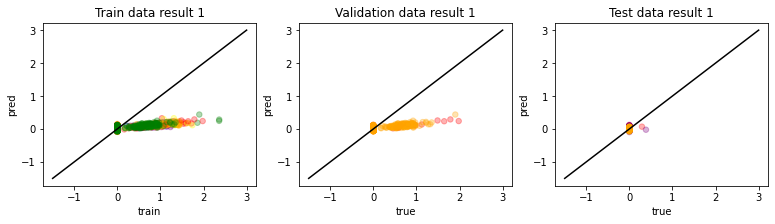

Epoch  10100 Train_loss:  0.09381024  Validation_loss:  0.10044926  Test_loss:  0.033710368
Epoch  10200 Train_loss:  0.09370877  Validation_loss:  0.10033135  Test_loss:  0.033774875
Epoch  10300 Train_loss:  0.09360661  Validation_loss:  0.10021323  Test_loss:  0.03383039
Epoch  10400 Train_loss:  0.093504354  Validation_loss:  0.10009465  Test_loss:  0.033901732
Epoch  10500 Train_loss:  0.09340161  Validation_loss:  0.099975705  Test_loss:  0.03395732
Epoch  10600 Train_loss:  0.093298554  Validation_loss:  0.099856265  Test_loss:  0.034021907
Epoch  10700 Train_loss:  0.0931947  Validation_loss:  0.09973612  Test_loss:  0.03408574
Epoch  10800 Train_loss:  0.09309088  Validation_loss:  0.099615306  Test_loss:  0.034148976
Epoch  10900 Train_loss:  0.092986636  Validation_loss:  0.099494375  Test_loss:  0.034215912
Epoch  11000 Train_loss:  0.09288166  Validation_loss:  0.09937278  Test_loss:  0.034280762


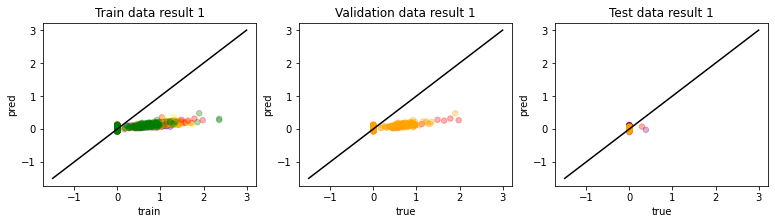

Epoch  11100 Train_loss:  0.09277634  Validation_loss:  0.09925068  Test_loss:  0.034351755
Epoch  11200 Train_loss:  0.092670746  Validation_loss:  0.099128194  Test_loss:  0.034414116
Epoch  11300 Train_loss:  0.09256464  Validation_loss:  0.099005245  Test_loss:  0.034485493
Epoch  11400 Train_loss:  0.092458345  Validation_loss:  0.098881245  Test_loss:  0.03455995
Epoch  11500 Train_loss:  0.09235092  Validation_loss:  0.09875719  Test_loss:  0.034626648
Epoch  11600 Train_loss:  0.09224378  Validation_loss:  0.09863257  Test_loss:  0.034690037
Epoch  11700 Train_loss:  0.092135824  Validation_loss:  0.098507166  Test_loss:  0.03476825
Epoch  11800 Train_loss:  0.09202752  Validation_loss:  0.0983814  Test_loss:  0.034844458
Epoch  11900 Train_loss:  0.09191902  Validation_loss:  0.09825546  Test_loss:  0.034900874
Epoch  12000 Train_loss:  0.091809824  Validation_loss:  0.09812865  Test_loss:  0.03498736


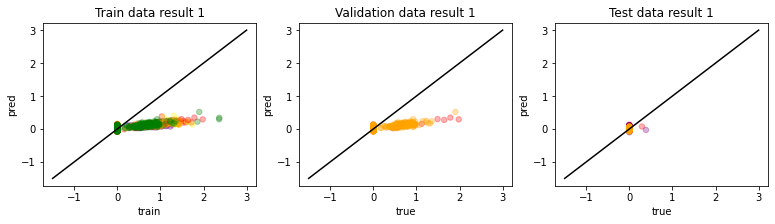

Epoch  12100 Train_loss:  0.09169997  Validation_loss:  0.098001175  Test_loss:  0.035057772
Epoch  12200 Train_loss:  0.09159006  Validation_loss:  0.097873956  Test_loss:  0.035116017
Epoch  12300 Train_loss:  0.09147919  Validation_loss:  0.09774521  Test_loss:  0.035193898
Epoch  12400 Train_loss:  0.09136796  Validation_loss:  0.09761632  Test_loss:  0.035273578
Epoch  12500 Train_loss:  0.09125654  Validation_loss:  0.097486824  Test_loss:  0.035349194
Epoch  12600 Train_loss:  0.09114457  Validation_loss:  0.09735704  Test_loss:  0.035421688
Epoch  12700 Train_loss:  0.09103195  Validation_loss:  0.09722675  Test_loss:  0.03549258
Epoch  12800 Train_loss:  0.090918906  Validation_loss:  0.0970955  Test_loss:  0.035573766
Epoch  12900 Train_loss:  0.090805285  Validation_loss:  0.09696381  Test_loss:  0.035647262
Epoch  13000 Train_loss:  0.0906912  Validation_loss:  0.09683177  Test_loss:  0.035720114


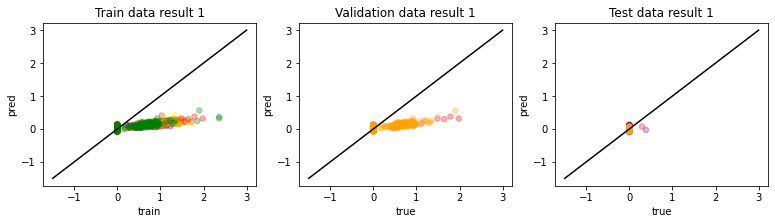

Epoch  13100 Train_loss:  0.090576425  Validation_loss:  0.09669895  Test_loss:  0.03579619
Epoch  13200 Train_loss:  0.09046121  Validation_loss:  0.0965655  Test_loss:  0.035878092
Epoch  13300 Train_loss:  0.09034563  Validation_loss:  0.09643138  Test_loss:  0.035952013
Epoch  13400 Train_loss:  0.090229444  Validation_loss:  0.096296914  Test_loss:  0.036034357
Epoch  13500 Train_loss:  0.090112895  Validation_loss:  0.09616244  Test_loss:  0.036101893
Epoch  13600 Train_loss:  0.08999585  Validation_loss:  0.09602666  Test_loss:  0.03618195
Epoch  13700 Train_loss:  0.08987793  Validation_loss:  0.09589057  Test_loss:  0.036263622
Epoch  13800 Train_loss:  0.08975972  Validation_loss:  0.09575388  Test_loss:  0.036349542
Epoch  13900 Train_loss:  0.08964094  Validation_loss:  0.095617056  Test_loss:  0.036422897
Epoch  14000 Train_loss:  0.08952187  Validation_loss:  0.09547923  Test_loss:  0.036500785


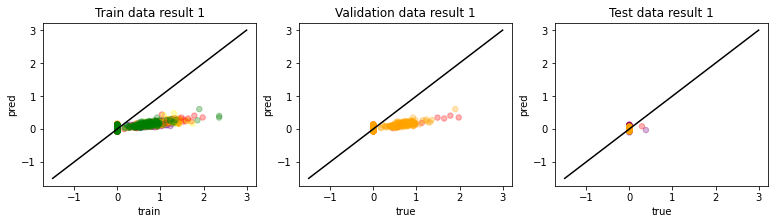

Epoch  14100 Train_loss:  0.08940233  Validation_loss:  0.09534065  Test_loss:  0.03658305
Epoch  14200 Train_loss:  0.08928193  Validation_loss:  0.09520187  Test_loss:  0.03665449
Epoch  14300 Train_loss:  0.08916098  Validation_loss:  0.09506186  Test_loss:  0.03674295
Epoch  14400 Train_loss:  0.08904016  Validation_loss:  0.09492161  Test_loss:  0.036827594
Epoch  14500 Train_loss:  0.088918224  Validation_loss:  0.09478098  Test_loss:  0.03690539
Epoch  14600 Train_loss:  0.08879538  Validation_loss:  0.0946395  Test_loss:  0.036989465
Epoch  14700 Train_loss:  0.08867258  Validation_loss:  0.09449713  Test_loss:  0.037076943
Epoch  14800 Train_loss:  0.08854929  Validation_loss:  0.094354846  Test_loss:  0.037150063
Epoch  14900 Train_loss:  0.08842536  Validation_loss:  0.09421178  Test_loss:  0.037228104
Epoch  15000 Train_loss:  0.0883007  Validation_loss:  0.094068184  Test_loss:  0.03731417


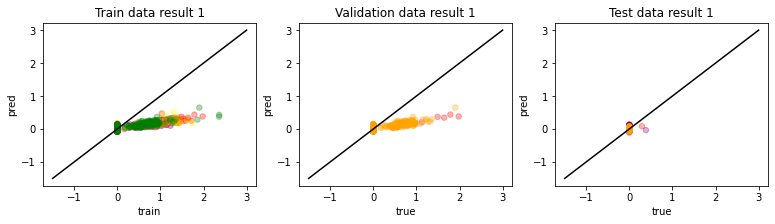

Epoch  15100 Train_loss:  0.088175915  Validation_loss:  0.09392365  Test_loss:  0.03739864
Epoch  15200 Train_loss:  0.08805019  Validation_loss:  0.093778625  Test_loss:  0.037482817
Epoch  15300 Train_loss:  0.08792412  Validation_loss:  0.09363321  Test_loss:  0.037563317
Epoch  15400 Train_loss:  0.08779773  Validation_loss:  0.09348715  Test_loss:  0.037650447
Epoch  15500 Train_loss:  0.087670125  Validation_loss:  0.0933407  Test_loss:  0.03773134
Epoch  15600 Train_loss:  0.087542035  Validation_loss:  0.09319353  Test_loss:  0.037814762
Epoch  15700 Train_loss:  0.087413885  Validation_loss:  0.0930456  Test_loss:  0.03790633
Epoch  15800 Train_loss:  0.08728497  Validation_loss:  0.092897154  Test_loss:  0.03798448
Epoch  15900 Train_loss:  0.087155715  Validation_loss:  0.09274815  Test_loss:  0.038063023
Epoch  16000 Train_loss:  0.08702523  Validation_loss:  0.092598505  Test_loss:  0.038148884


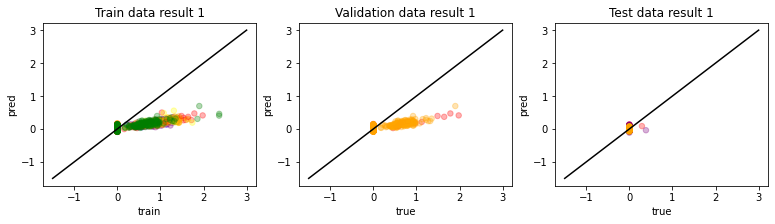

Epoch  16100 Train_loss:  0.086894765  Validation_loss:  0.09244793  Test_loss:  0.038238812
Epoch  16200 Train_loss:  0.08676387  Validation_loss:  0.092296936  Test_loss:  0.038316082
Epoch  16300 Train_loss:  0.08663214  Validation_loss:  0.092145205  Test_loss:  0.038400766
Epoch  16400 Train_loss:  0.08649968  Validation_loss:  0.09199274  Test_loss:  0.038485814
Epoch  16500 Train_loss:  0.086366676  Validation_loss:  0.091839895  Test_loss:  0.038573653
Epoch  16600 Train_loss:  0.08623338  Validation_loss:  0.09168636  Test_loss:  0.038657017
Epoch  16700 Train_loss:  0.08609925  Validation_loss:  0.091532245  Test_loss:  0.03874674
Epoch  16800 Train_loss:  0.085964635  Validation_loss:  0.0913776  Test_loss:  0.03882598
Epoch  16900 Train_loss:  0.085830115  Validation_loss:  0.09122261  Test_loss:  0.038912833
Epoch  17000 Train_loss:  0.08569413  Validation_loss:  0.091066964  Test_loss:  0.038987957


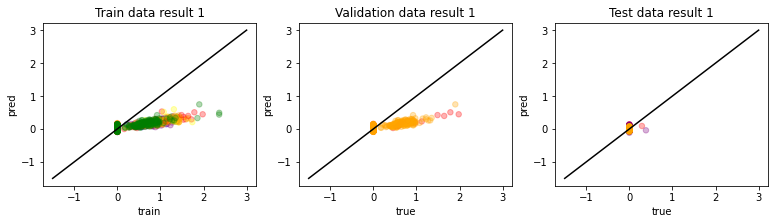

Epoch  17100 Train_loss:  0.08555809  Validation_loss:  0.09091085  Test_loss:  0.0390731
Epoch  17200 Train_loss:  0.08542139  Validation_loss:  0.090753585  Test_loss:  0.039160173
Epoch  17300 Train_loss:  0.085283935  Validation_loss:  0.0905961  Test_loss:  0.039243463
Epoch  17400 Train_loss:  0.085146286  Validation_loss:  0.0904374  Test_loss:  0.039332356
Epoch  17500 Train_loss:  0.08500769  Validation_loss:  0.09027869  Test_loss:  0.03941094
Epoch  17600 Train_loss:  0.08486888  Validation_loss:  0.090119176  Test_loss:  0.03950375
Epoch  17700 Train_loss:  0.08472945  Validation_loss:  0.089959055  Test_loss:  0.039590202
Epoch  17800 Train_loss:  0.08458912  Validation_loss:  0.08979839  Test_loss:  0.03967352
Epoch  17900 Train_loss:  0.08444831  Validation_loss:  0.0896371  Test_loss:  0.039750744
Epoch  18000 Train_loss:  0.08430739  Validation_loss:  0.08947603  Test_loss:  0.039833546


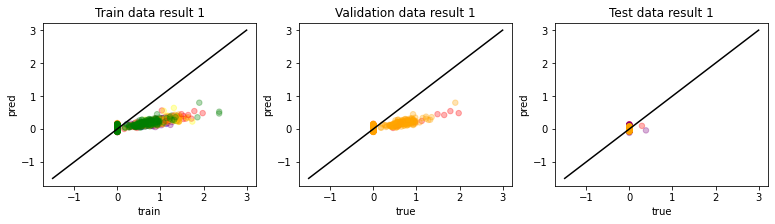

Epoch  18100 Train_loss:  0.084165715  Validation_loss:  0.08931341  Test_loss:  0.039927505
Epoch  18200 Train_loss:  0.08402368  Validation_loss:  0.08915056  Test_loss:  0.040009018
Epoch  18300 Train_loss:  0.083881326  Validation_loss:  0.088987365  Test_loss:  0.04008599
Epoch  18400 Train_loss:  0.083737805  Validation_loss:  0.08882347  Test_loss:  0.040169135
Epoch  18500 Train_loss:  0.083594516  Validation_loss:  0.08865893  Test_loss:  0.04026109
Epoch  18600 Train_loss:  0.0834499  Validation_loss:  0.08849406  Test_loss:  0.040343486
Epoch  18700 Train_loss:  0.08330511  Validation_loss:  0.08832809  Test_loss:  0.040431816
Epoch  18800 Train_loss:  0.0831593  Validation_loss:  0.08816183  Test_loss:  0.04052029
Epoch  18900 Train_loss:  0.08301345  Validation_loss:  0.08799563  Test_loss:  0.040591463
Epoch  19000 Train_loss:  0.08286698  Validation_loss:  0.08782788  Test_loss:  0.040677745


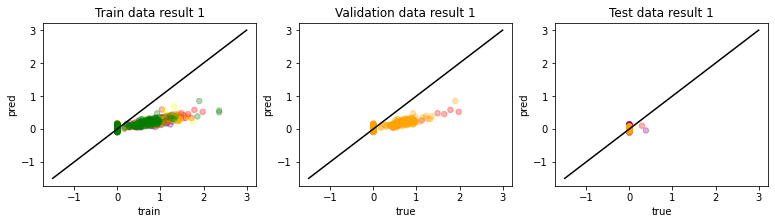

Epoch  19100 Train_loss:  0.08271996  Validation_loss:  0.087659895  Test_loss:  0.040768016
Epoch  19200 Train_loss:  0.08257243  Validation_loss:  0.08749132  Test_loss:  0.040848136
Epoch  19300 Train_loss:  0.08242418  Validation_loss:  0.08732241  Test_loss:  0.04093292
Epoch  19400 Train_loss:  0.0822757  Validation_loss:  0.08715294  Test_loss:  0.041013777
Epoch  19500 Train_loss:  0.08212667  Validation_loss:  0.086982384  Test_loss:  0.04110406
Epoch  19600 Train_loss:  0.08197731  Validation_loss:  0.086811475  Test_loss:  0.041184645
Epoch  19700 Train_loss:  0.081826635  Validation_loss:  0.08664026  Test_loss:  0.04127013
Epoch  19800 Train_loss:  0.08167639  Validation_loss:  0.08646886  Test_loss:  0.041345507
Epoch  19900 Train_loss:  0.08152541  Validation_loss:  0.08629636  Test_loss:  0.041433226
Epoch  20000 Train_loss:  0.08137298  Validation_loss:  0.08612291  Test_loss:  0.04152529


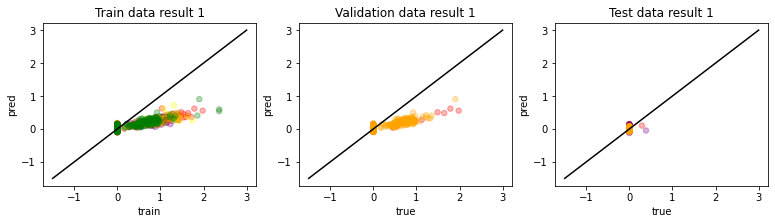

In [57]:
num_epochs = 20001
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load(PATH))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_pred_np, train_output_np, val_pred_np, val_output_np = fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output)

Epoch  0 Train_loss:  0.08137152  Validation_loss:  0.08612127  Test_loss:  0.041524682


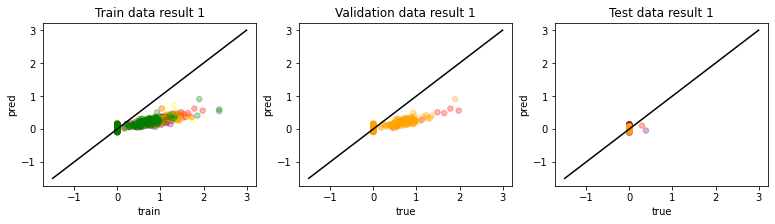

Epoch  100 Train_loss:  0.07995492  Validation_loss:  0.08450914  Test_loss:  0.042282812
Epoch  200 Train_loss:  0.07836468  Validation_loss:  0.08270323  Test_loss:  0.04313571
Epoch  300 Train_loss:  0.07672931  Validation_loss:  0.08084958  Test_loss:  0.043923866
Epoch  400 Train_loss:  0.07504938  Validation_loss:  0.07895107  Test_loss:  0.04473973
Epoch  500 Train_loss:  0.07333062  Validation_loss:  0.07701305  Test_loss:  0.045489
Epoch  600 Train_loss:  0.07157646  Validation_loss:  0.07504183  Test_loss:  0.046223782
Epoch  700 Train_loss:  0.0697922  Validation_loss:  0.07303923  Test_loss:  0.04695052
Epoch  800 Train_loss:  0.06798327  Validation_loss:  0.0710156  Test_loss:  0.047628585
Epoch  900 Train_loss:  0.06615738  Validation_loss:  0.06897765  Test_loss:  0.048286673
Epoch  1000 Train_loss:  0.06432004  Validation_loss:  0.06693691  Test_loss:  0.048911802


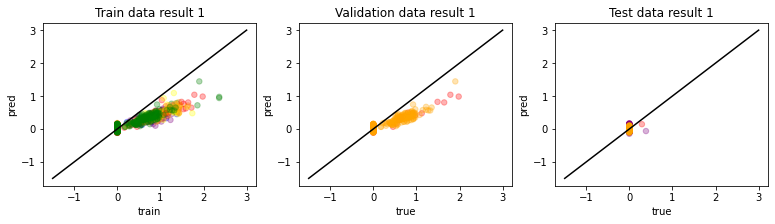

Epoch  1100 Train_loss:  0.06247492  Validation_loss:  0.06488585  Test_loss:  0.04953847
Epoch  1200 Train_loss:  0.060631864  Validation_loss:  0.06284126  Test_loss:  0.050105248
Epoch  1300 Train_loss:  0.05879527  Validation_loss:  0.060811203  Test_loss:  0.05063901
Epoch  1400 Train_loss:  0.056971617  Validation_loss:  0.0587988  Test_loss:  0.051154405
Epoch  1500 Train_loss:  0.055166606  Validation_loss:  0.056809712  Test_loss:  0.051612142
Epoch  1600 Train_loss:  0.053384155  Validation_loss:  0.05485526  Test_loss:  0.05203063
Epoch  1700 Train_loss:  0.051627044  Validation_loss:  0.052935433  Test_loss:  0.05248691
Epoch  1800 Train_loss:  0.0499072  Validation_loss:  0.051059797  Test_loss:  0.052869175
Epoch  1900 Train_loss:  0.0482214  Validation_loss:  0.049224764  Test_loss:  0.05321111
Epoch  2000 Train_loss:  0.046576474  Validation_loss:  0.047438398  Test_loss:  0.053585634


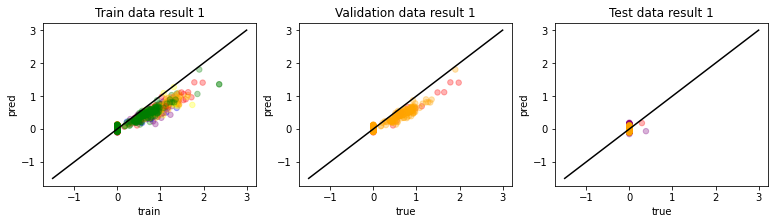

Epoch  2100 Train_loss:  0.044974517  Validation_loss:  0.045703355  Test_loss:  0.053895842
Epoch  2200 Train_loss:  0.04341661  Validation_loss:  0.044029642  Test_loss:  0.054155964
Epoch  2300 Train_loss:  0.0419069  Validation_loss:  0.04240371  Test_loss:  0.054377805
Epoch  2400 Train_loss:  0.040443946  Validation_loss:  0.04083994  Test_loss:  0.05459969
Epoch  2500 Train_loss:  0.039031252  Validation_loss:  0.03932397  Test_loss:  0.054803252
Epoch  2600 Train_loss:  0.037673645  Validation_loss:  0.037875604  Test_loss:  0.054949973
Epoch  2700 Train_loss:  0.03636263  Validation_loss:  0.03648323  Test_loss:  0.05510354
Epoch  2800 Train_loss:  0.035105474  Validation_loss:  0.03514507  Test_loss:  0.055211835
Epoch  2900 Train_loss:  0.03389462  Validation_loss:  0.03386732  Test_loss:  0.05534855
Epoch  3000 Train_loss:  0.03273487  Validation_loss:  0.032643106  Test_loss:  0.055466615


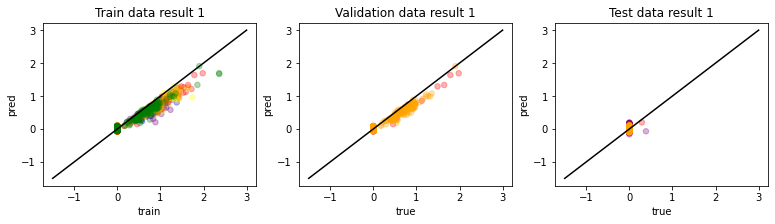

Epoch  3100 Train_loss:  0.031624593  Validation_loss:  0.031473096  Test_loss:  0.055533636
Epoch  3200 Train_loss:  0.030568073  Validation_loss:  0.030360747  Test_loss:  0.055568423
Epoch  3300 Train_loss:  0.029550724  Validation_loss:  0.029282585  Test_loss:  0.055670816
Epoch  3400 Train_loss:  0.028587028  Validation_loss:  0.028280117  Test_loss:  0.0556463
Epoch  3500 Train_loss:  0.027657906  Validation_loss:  0.02730687  Test_loss:  0.055673823
Epoch  3600 Train_loss:  0.026774583  Validation_loss:  0.026388744  Test_loss:  0.0556875
Epoch  3700 Train_loss:  0.025938764  Validation_loss:  0.02552432  Test_loss:  0.05565766
Epoch  3800 Train_loss:  0.025138777  Validation_loss:  0.02470412  Test_loss:  0.05559565
Epoch  3900 Train_loss:  0.024366291  Validation_loss:  0.023902984  Test_loss:  0.055596974
Epoch  4000 Train_loss:  0.023642214  Validation_loss:  0.023172434  Test_loss:  0.055503316


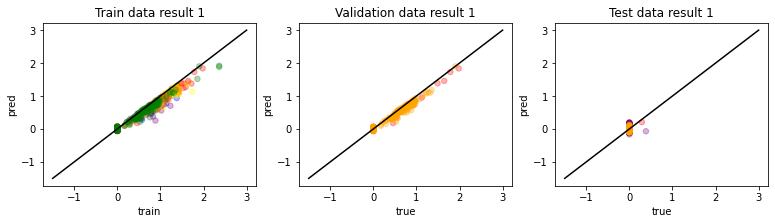

Epoch  4100 Train_loss:  0.022945203  Validation_loss:  0.022446292  Test_loss:  0.055481564
Epoch  4200 Train_loss:  0.022280687  Validation_loss:  0.021769319  Test_loss:  0.055426873
Epoch  4300 Train_loss:  0.021648007  Validation_loss:  0.021129327  Test_loss:  0.055336908
Epoch  4400 Train_loss:  0.021049427  Validation_loss:  0.020529814  Test_loss:  0.055233534
Epoch  4500 Train_loss:  0.02047428  Validation_loss:  0.019950809  Test_loss:  0.05518118
Epoch  4600 Train_loss:  0.019922646  Validation_loss:  0.01939345  Test_loss:  0.055085387
Epoch  4700 Train_loss:  0.019400856  Validation_loss:  0.018869188  Test_loss:  0.054993387
Epoch  4800 Train_loss:  0.01890356  Validation_loss:  0.018373013  Test_loss:  0.05488519
Epoch  4900 Train_loss:  0.018425342  Validation_loss:  0.017887183  Test_loss:  0.054801103
Epoch  5000 Train_loss:  0.017976519  Validation_loss:  0.017447462  Test_loss:  0.054642912


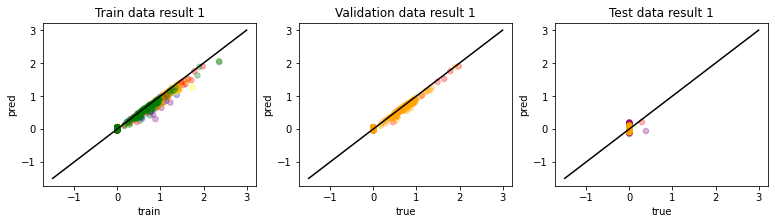

Epoch  5100 Train_loss:  0.017552529  Validation_loss:  0.017027913  Test_loss:  0.05456595
Epoch  5200 Train_loss:  0.017139254  Validation_loss:  0.016622286  Test_loss:  0.054480612
Epoch  5300 Train_loss:  0.016748326  Validation_loss:  0.016240718  Test_loss:  0.054341286
Epoch  5400 Train_loss:  0.016373906  Validation_loss:  0.015873674  Test_loss:  0.054215483
Epoch  5500 Train_loss:  0.016016576  Validation_loss:  0.015533088  Test_loss:  0.054111388
Epoch  5600 Train_loss:  0.015675377  Validation_loss:  0.015208533  Test_loss:  0.053984698


KeyboardInterrupt: 

In [58]:
num_epochs = 50001
learning_rate = 0.01
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
model.load_state_dict(torch.load(PATH))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_pred_np, train_output_np, val_pred_np, val_output_np = fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output)